# Production modelling

In [40]:
# Libraries and parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate, learning_curve, GridSearchCV

from imblearn.over_sampling import SMOTE

In [2]:
#Loading X_train, y_train, X_test, y_test from .csv creating in preprocessing

X_train = pd.read_csv('../preproc_data/X_train_preproc.csv', index_col=0)
y_train = pd.read_csv('../preproc_data/y_train.csv', index_col=0)["y_target"]

X_test = pd.read_csv('../preproc_data/X_test_preproc.csv', index_col=0)
y_test = pd.read_csv('../preproc_data/y_test.csv', index_col=0)["y_target"]

## Logistic Regression with unbalanced dataset

In [5]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [7]:
y_pred = model.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6998344370860927
Recall = 0.11301472798316801
Precision = 0.6290255123379339


## Logistic regretion with balanced dataset

In [8]:
#Utilizing the SMOTE method to resample X_train, y_train to balance the data set\n",
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [10]:
y_pred = model.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.601158940397351
Recall = 0.58551247370003
Precision = 0.40712680913318355


## Gradient Boosting Classifier

In [47]:
clf = GradientBoostingClassifier(loss="log_loss", n_estimators=1000)

In [48]:
clf.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(n_estimators=1000)

In [49]:
y_pred = clf.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.7259460737937559
Recall = 0.2671325518485122
Precision = 0.6596771200593802


In [51]:
params = {"n_estimators": [100, 1000, 10000], "learning_rate": [0.01, 0.1, 1]}

search = GridSearchCV(estimator=GradientBoostingClassifier(),
                      param_grid=params,
                      scoring="accuracy",
                      cv=5,
                      n_jobs=-1)

search.fit(X_train_resampled, y_train_resampled)

In [25]:
cv_results = cross_validate(GradientBoostingClassifier(), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1, scoring="accuracy")

In [39]:
# Get train scores (Accuracy), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=GradientBoostingClassifier(), X=X_train_resampled, y=y_train_resampled, cv=5)

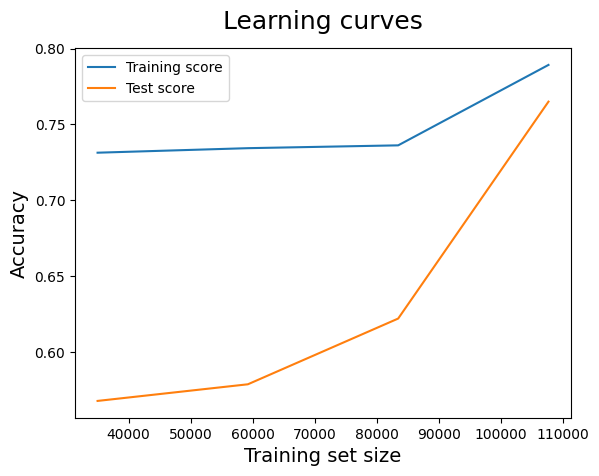

In [41]:
# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

## Random Forest Classifier

In [15]:
rdc = RandomForestClassifier()
rdc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [16]:
y_pred = rdc.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.7112109744560076
Recall = 0.23331830477908025
Precision = 0.6073943661971831


## SGDC Classifier

In [19]:
sgdc = SGDClassifier()
sgdc.fit(X_train_resampled, y_train_resampled)

SGDClassifier()

In [20]:
y_pred = sgdc.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.5631031220435194
Recall = 0.6578749624286143
Precision = 0.38612507718091205
